## Time Series Data Analysis using RNN

In [1]:
# in this code block we gather all imports

# to read CSV and for use with the library ppscore
import pandas as pd
from pandas.api.types import CategoricalDtype

# for use with sklearn and for EDA
import numpy as np

# Data Split
from sklearn.model_selection import train_test_split

# Normalization and Standardization
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Plots
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm

# EDA
import ppscore as pps
from scipy import stats

# PCA
from sklearn.decomposition import PCA

# Tensors and Artificial Neural Networks
import torch
import torch.nn as nn



In [2]:
# in this code block we determine the device to use depending on GPU availability

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Computation is running on {}.'.format(device))

This Computation is running on cpu.


In [3]:
# in this code block we generate a series bases on the sinus function

def create_example_sinus_time_series():
    # number of samples == number of time series
    n = 5
    # number of actual values per time series
    l = 1000
    # parameter that governs the width of a sine wave
    sine_wave_width = 20
    
    # create some input for the sine function
    x = np.empty((n, l), np.float32)
    x[:] = np.array(range(l)) + np.random.randint(-4 * sine_wave_width, 4 * sine_wave_width, n).reshape(n, 1)

    print(f"x.shape={x.shape}")

    # get the corresponding sine values
    y = np.sin(x / 1.0 / sine_wave_width).astype(np.float32)

    print(f"y.shape={y.shape}")

    # plot of the first sine wave n = 1 and second sine wave n = 2
    plt.figure(figsize=(16,9))
    plt.title("Sine wave example")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(np.arange(x.shape[1]), y[0,:], linestyle='',marker='.',markersize=11.,markerfacecolor='#8080ff',markeredgewidth=.0)
    plt.plot(np.arange(x.shape[1]), y[1,:], linestyle='',marker='.',markersize=11.,markerfacecolor='#ffb380',markeredgewidth=.0)
    plt.show()

    # 97 samples aka. time series
    # 999 values per time series
    # the last 97 time series
    # each with all its values except the last one
    train_series_input_np = y[3:, :-1]
    train_series_input = torch.from_numpy(train_series_input_np)
    print(f"train_series.shape={train_series_input.shape}")

    # 97 samples aka. time series
    # 999 values per time series
    # the last 97 time series
    # each with all its values except the first one
    train_series_target_np = y[3:, 1:]
    train_series_target = torch.from_numpy(train_series_target_np)
    print(f"train_series_target.shape={train_series_target.shape}")

    # 97 samples aka. time series
    # 999 values per time series
    # the first three time series
    # each with all its values except the last one
    test_series_input_np = y[:3, :-1]
    test_series_input = torch.from_numpy(test_series_input_np)
    print(f"test_series_input.shape={test_series_input.shape}")

    # 97 samples aka. time series
    # 999 values per time series
    # the first three time series
    # each with all its values except the first one
    test_series_target_np = y[:3, 1:]
    test_series_target = torch.from_numpy(test_series_target_np)
    print(f"test_series_target.shape={test_series_target.shape}")

    return y, train_series_input, train_series_target, test_series_input, test_series_target


In [4]:
# in this code block we define a long short-term memory neural network

class LSTMTimeSeriesPredictor(nn.Module):
    def __init__(self, n_hidden=42):
        super(LSTMTimeSeriesPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm, lstm, linear
        # 1 input since in each step we consume only 1 value of a time series
        self.lstm_1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm_2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
        # 1 output since in each step we predict only 1 value of a time series

    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)

        # initial hidden states of LSTM cell 1
        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        # initial cell states of LSTM cell 1
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        # initial hidden states of LSTM cell 2
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        # initial cell states of LSTM cell 2
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

        # split tensor into chunks
        # technically each chunk is a view on the tensor
        for input_t in x.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm_1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm_2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future):
            h_t, c_t = self.lstm_1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm_2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)            

        outputs = torch.cat(outputs, dim=1)
        return outputs


x.shape=(5, 1000)
y.shape=(5, 1000)


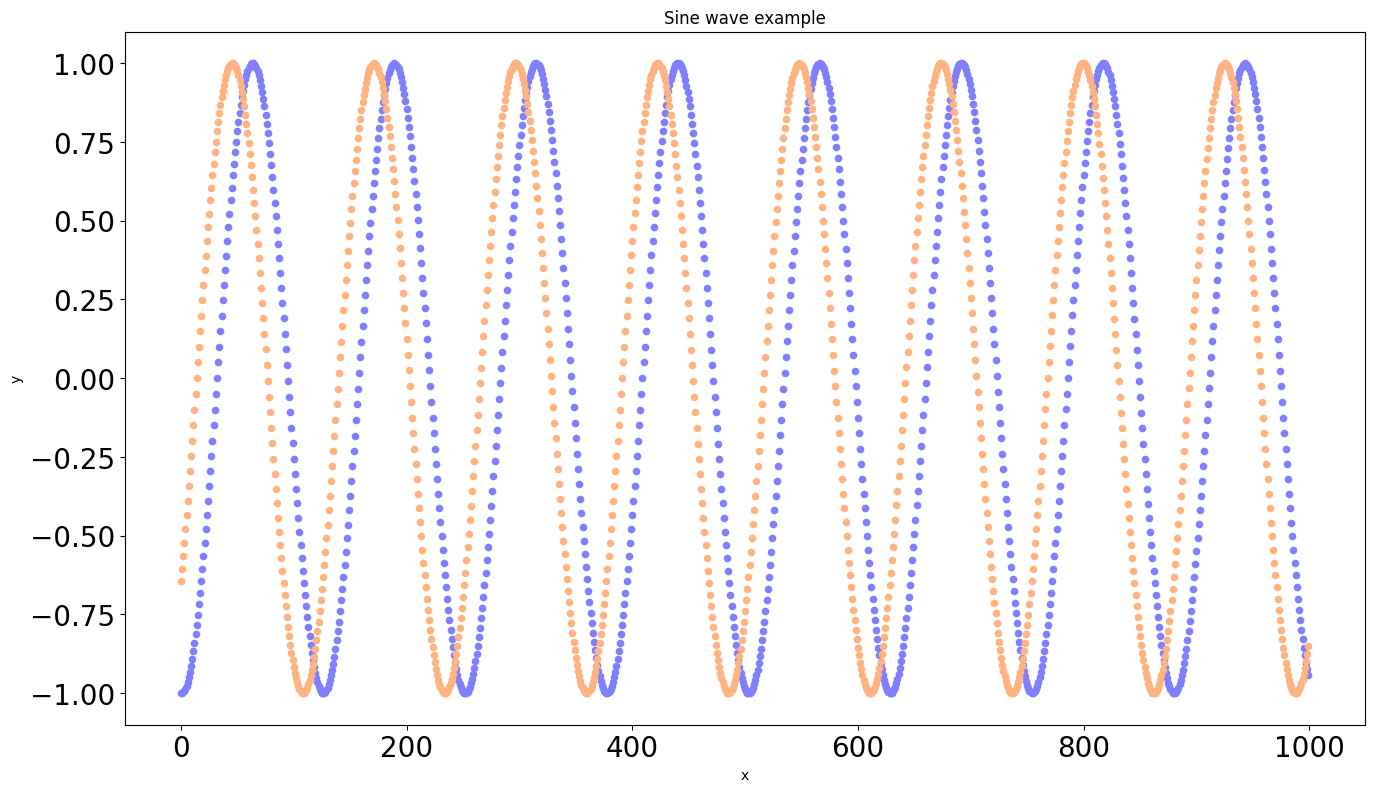

train_series.shape=torch.Size([2, 999])
train_series_target.shape=torch.Size([2, 999])
test_series_input.shape=torch.Size([3, 999])
test_series_target.shape=torch.Size([3, 999])
step=0
train loss: 0.4923035800457001
train loss: 0.4919041097164154
train loss: 0.4807848036289215
train loss: 0.43699997663497925
train loss: 0.3547983467578888
train loss: 0.3310917615890503
train loss: 0.2950851619243622
train loss: 0.22556456923484802
train loss: 0.20727026462554932
train loss: 0.18528462946414948
train loss: 0.14446920156478882
train loss: 0.11014453321695328
train loss: 0.08788691461086273
train loss: 0.07154413312673569
train loss: 0.05911336466670036
train loss: 0.04968712851405144
train loss: 0.04249505326151848
train loss: 0.036950286477804184
train loss: 0.03263351693749428
train loss: 0.029244884848594666
test loss: 0.028203919529914856
step=1
train loss: 0.02656623348593712
train loss: 0.02443591132760048
train loss: 0.022732192650437355
train loss: 0.021362314000725746
train loss

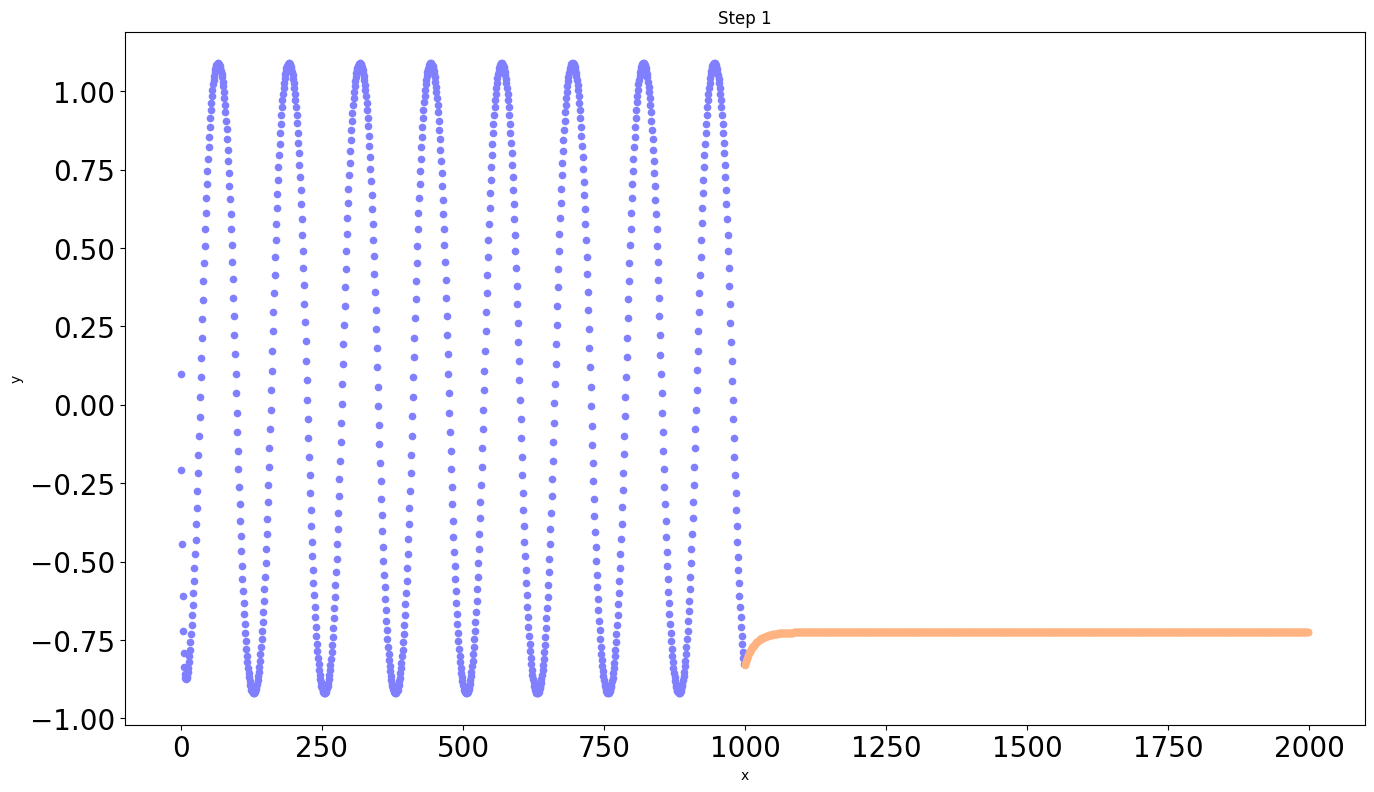

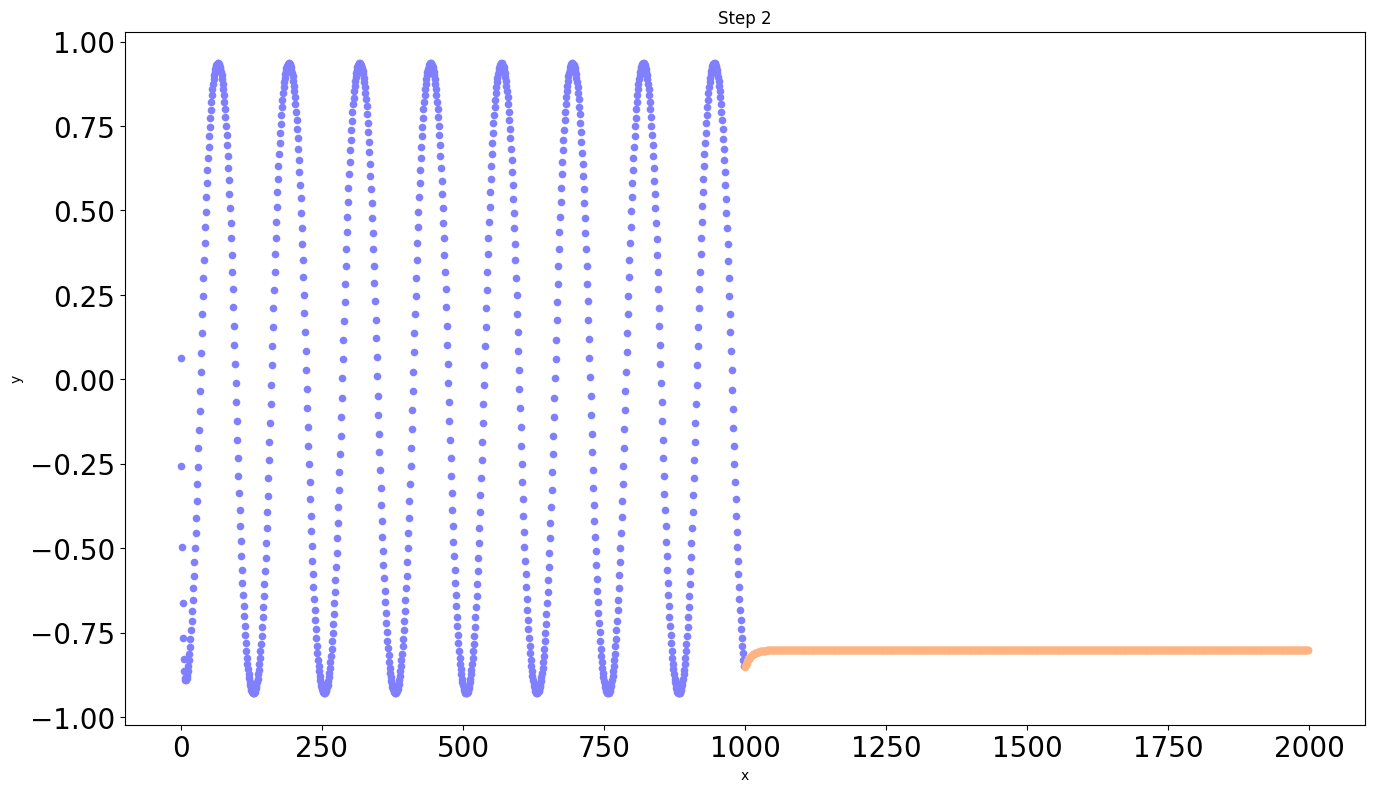

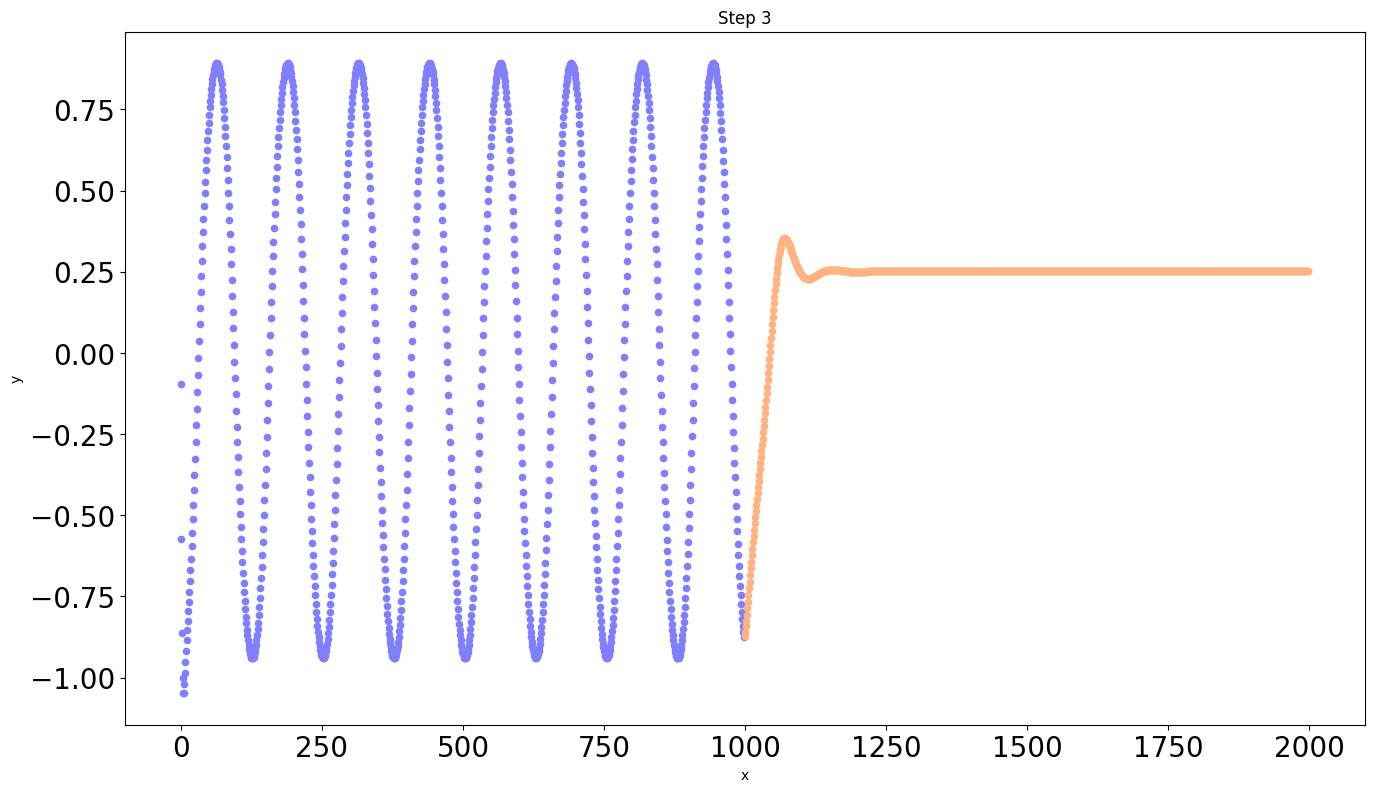

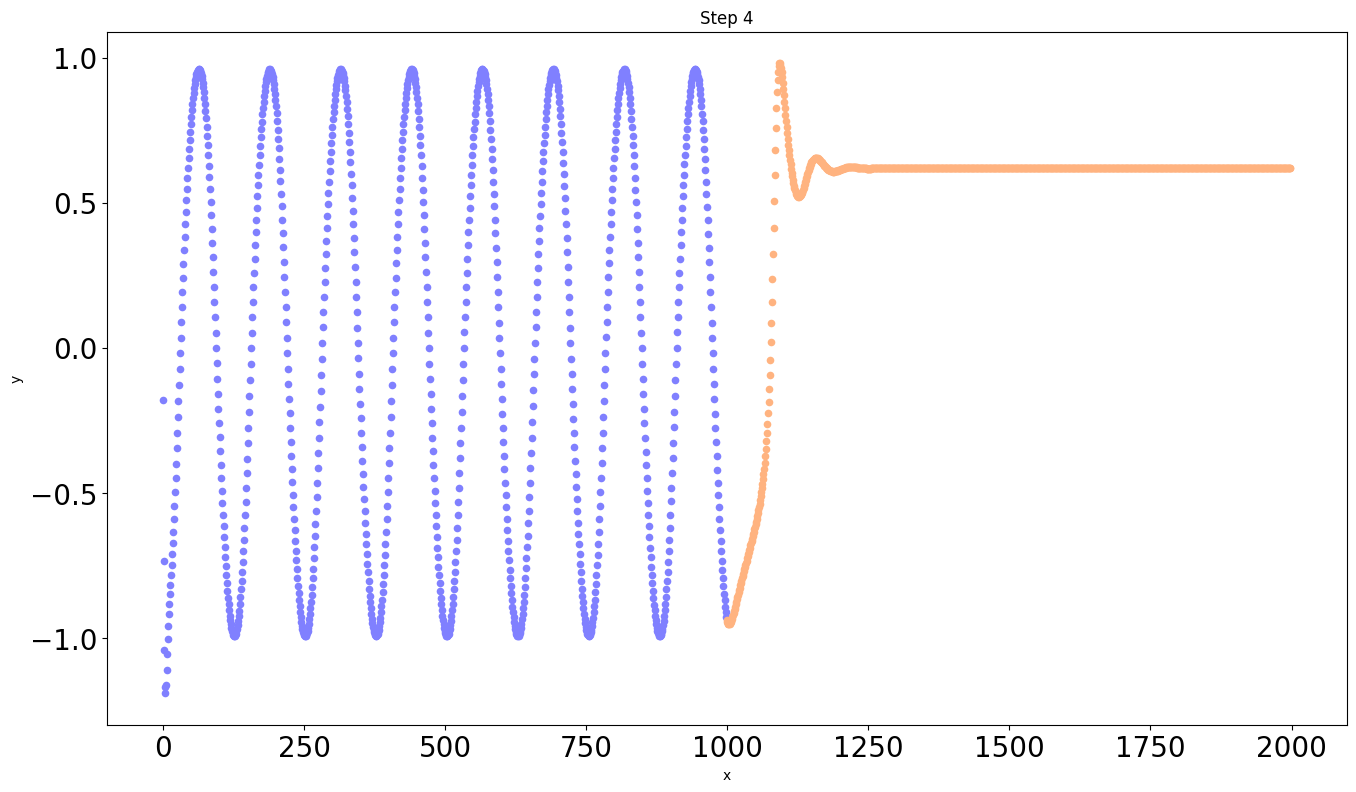

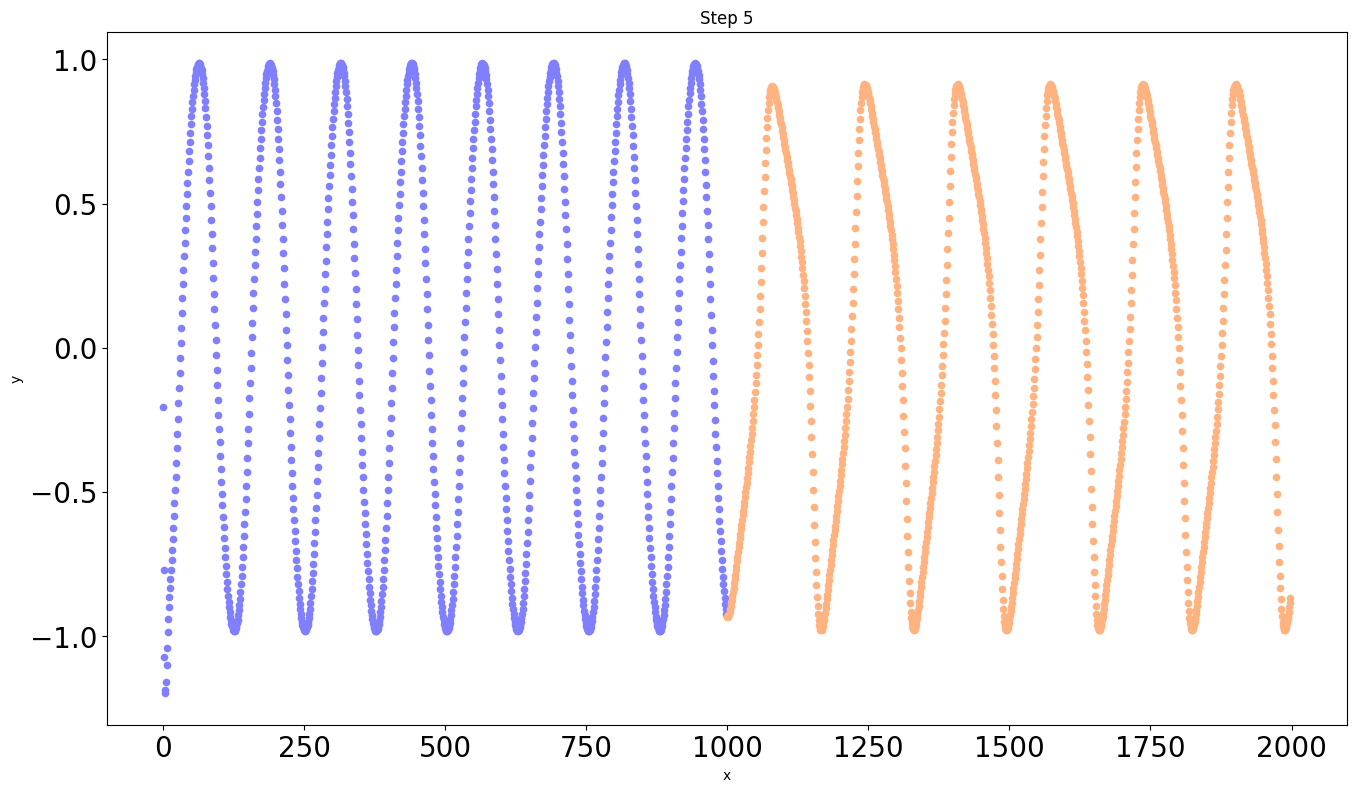

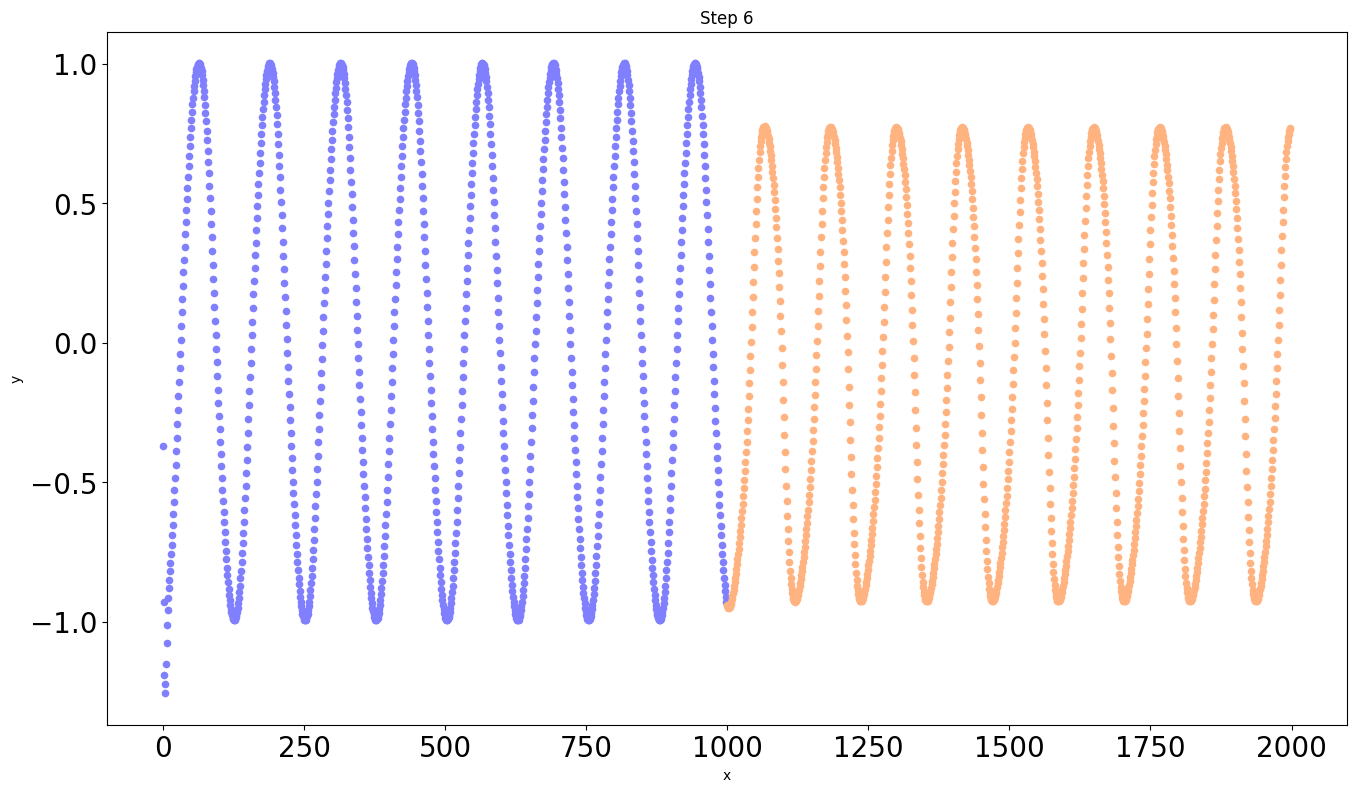

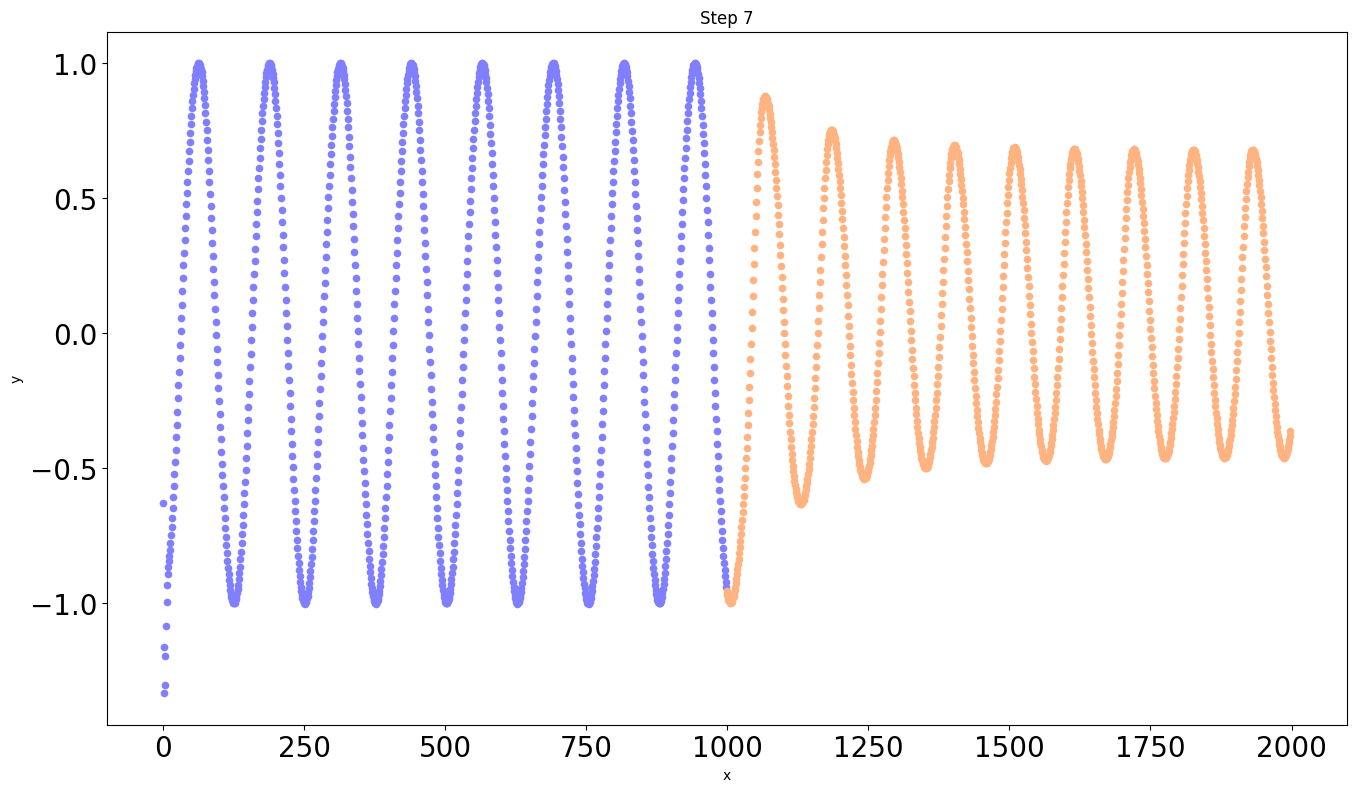

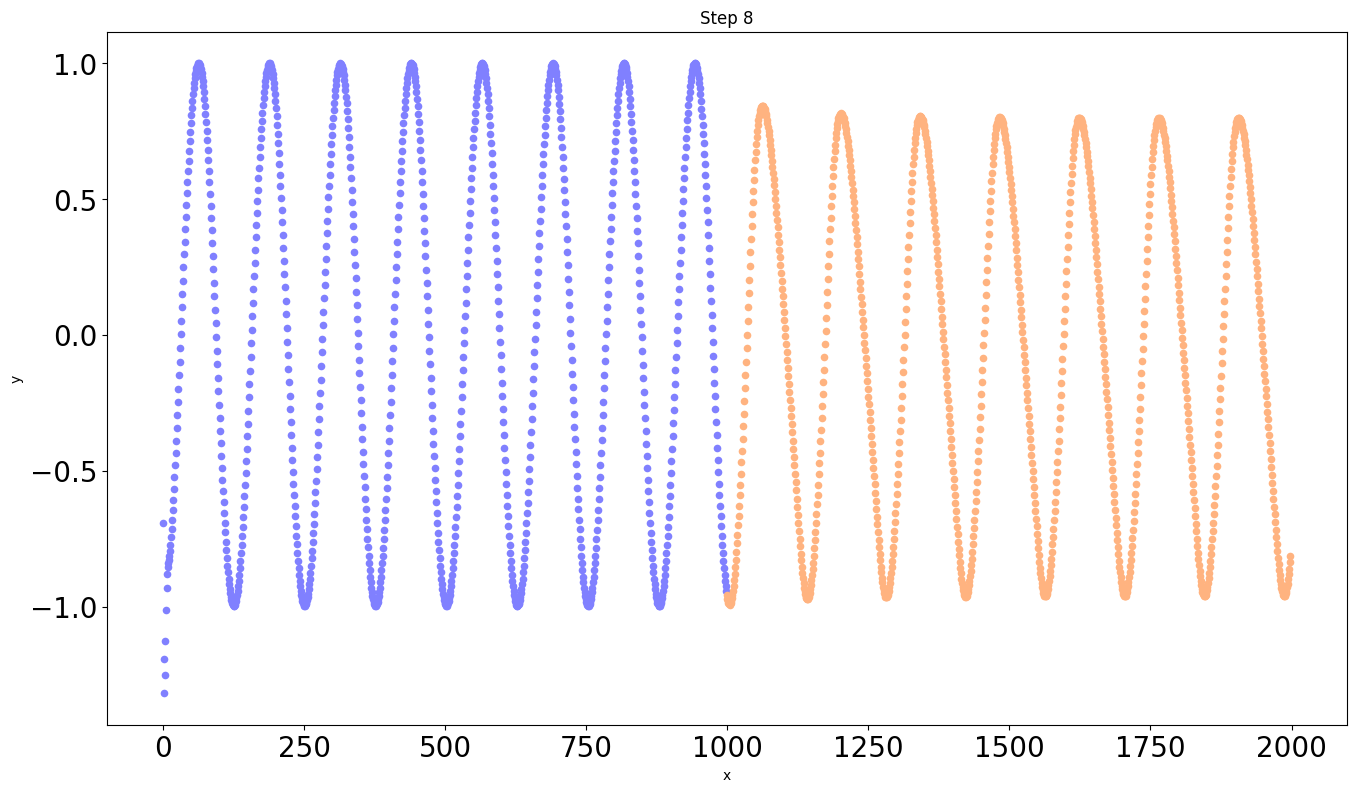

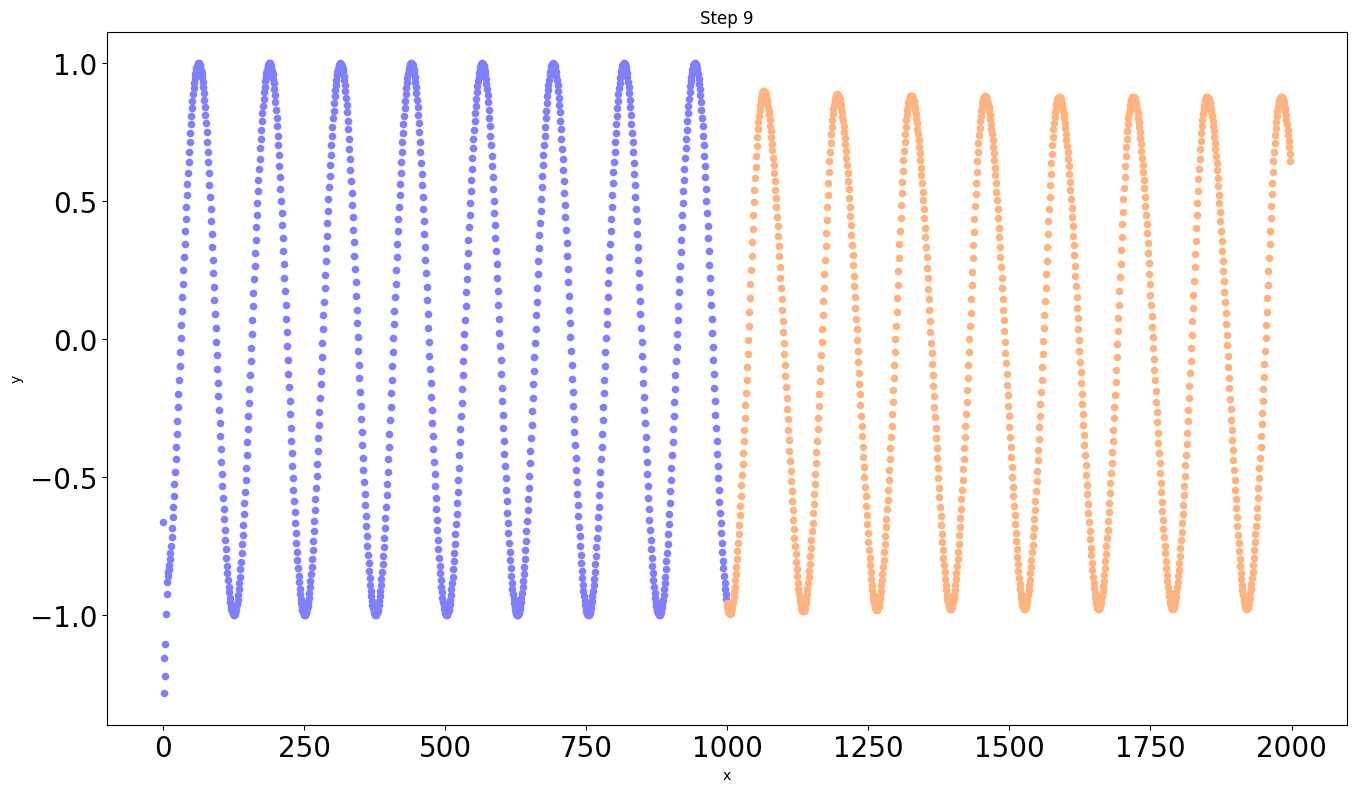

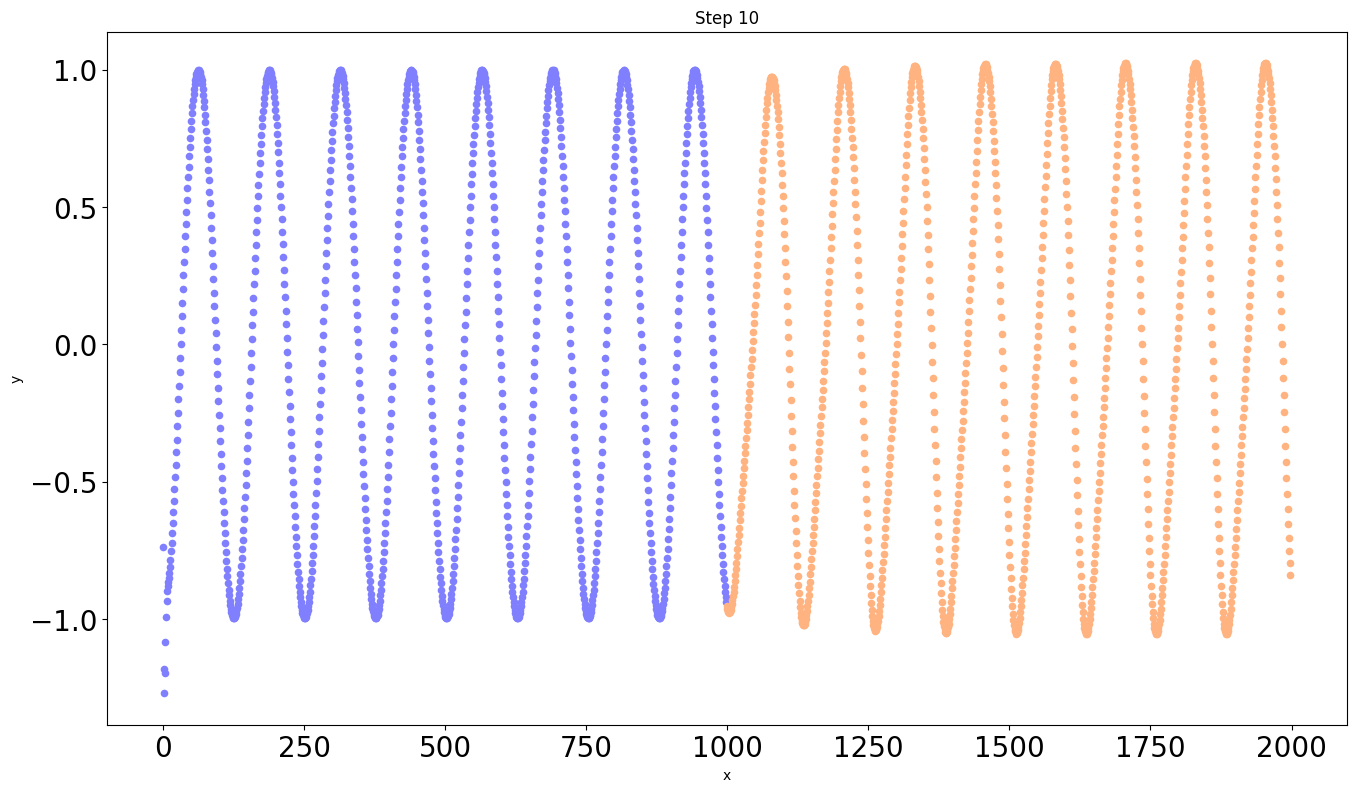

In [5]:
# in this code we train and test the LSTM NN

y, train_series_input, train_series_target, test_series_input, test_series_target = create_example_sinus_time_series()

model = LSTMTimeSeriesPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)

n_steps = 10
for step_i in range(n_steps):
    print(f"step={step_i}")

    # train
    def closure():
        optimizer.zero_grad()
        out_i = model(train_series_input)
        l_train_i = criterion(out_i, train_series_target)
        print('train loss:', l_train_i.item())
        l_train_i.backward()
        return l_train_i
    
    optimizer.step(closure)

    # predict
    with torch.no_grad():
        n_future_values=1000
        y_test_i = model(test_series_input, future=n_future_values)
        l_test = criterion(y_test_i[:, :-n_future_values], test_series_target)
        print('test loss:', l_test.item())
        y_test_i_np = y_test_i.detach().numpy()

    # plot of the first sine wave n = 1 and second sine wave n = 2
    plt.figure(figsize=(16,9))
    plt.title(f"Step {step_i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    n_train_values = train_series_input.shape[1] # 999
    def draw(y_np):
        # draw the actual values
        plt.plot(np.arange(n_train_values), y_np[:n_train_values], linestyle='', marker='.', markersize=11., markerfacecolor='#8080ff', markeredgewidth=.0)
        # draw the predicted values
        plt.plot(np.arange(n_train_values, n_train_values + n_future_values), y_np[n_train_values:], linestyle='', marker='.', markersize=11., markerfacecolor='#ffb380', markeredgewidth=.0)
    
    draw(y_test_i_np[0])

